Import

In [1]:
import cv2
from matplotlib import pyplot as plt
import json
import math
import time
import numpy as np
import tensorflow as tf

Data

In [2]:
# Load annotations file
json_file_path = "D:/coco_wholebody_val_v1.0.json"
with open(json_file_path, "r") as f:
    annotations = json.load(f)

# Load image file
annos = annotations["annotations"]


In [3]:
image_ids = []
temp = []
for anno in annos:
    if anno["num_keypoints"] == 17 or anno["image_id"] in image_ids:
        temp.append(anno["image_id"])
for anno in annos:
    if anno["image_id"] in temp:
        image_ids.append(anno["image_id"])
image_ids = [x for x in image_ids if image_ids.count(x) == 1]
len(image_ids)

82

In [4]:
image_path = "D:/val2017/"

In [5]:
image_paths = []
for  image_id in image_ids:
    image_name = str(image_id)
    for i in range(12-len(image_name)):
        image_name = "0"+image_name
    image_path = "D:/val2017/" + image_name + ".jpg"
    image_paths.append(image_path)
image_paths[3]

'D:/val2017/000000481573.jpg'

In [6]:
len(image_paths)

82

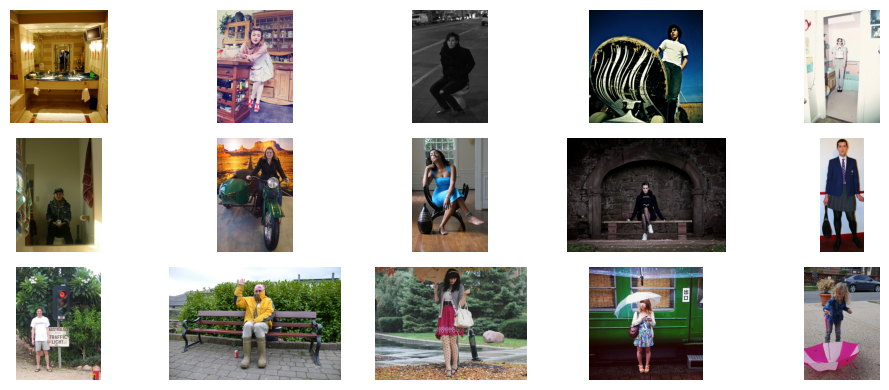

In [9]:
fig, axes = plt.subplots(3, 5, figsize=(10, 4))

# Loop through the images and plot them
for i in range(15):
    # Read the image using OpenCV (replace with your image loading code)
    plt.subplot(3,5,i+1)

    image = cv2.imread(image_paths[i])
    
    # Convert BGR to RGB (if needed)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(image)
    
    # Remove axis labels and ticks
    plt.axis("off")

# Adjust layout to prevent clipping of axis labels
plt.tight_layout()

In [8]:
test = []
for anno in annos:
    keypoints = []
    if anno["image_id"] in image_ids:
        keypoint_coords = anno["keypoints"]
        for i in range(0, len(keypoint_coords), 3):
            x = int(keypoint_coords[i])
            y = int(keypoint_coords[i + 1])
            keypoints.append([x,y])
        test.append(keypoints)
test[1]

[[220, 159],
 [233, 148],
 [206, 147],
 [247, 166],
 [186, 154],
 [255, 204],
 [150, 206],
 [196, 267],
 [152, 267],
 [134, 256],
 [179, 303],
 [253, 291],
 [196, 310],
 [248, 408],
 [223, 406],
 [229, 524],
 [200, 493]]

In [9]:
len(test)

82

Load model

In [10]:
interpreter = tf.lite.Interpreter(model_path="3.tflite")
interpreter.allocate_tensors()

In [23]:
pred = []
for image_path in image_paths:    
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    image = tf.expand_dims(image, axis=0)
    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    image = tf.image.resize_with_pad(image, 192, 192)
    # TF Lite format expects tensor type of float32.
    input_image = tf.cast(image, dtype=tf.float32)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints = []
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    keypoints_with_scores = np.squeeze(np.multiply(keypoints_with_scores, [height,width,1]))
    for i in range(len(keypoints_with_scores)):
        keypoints.append([keypoints_with_scores[i][1], keypoints_with_scores[i][0]])
    pred.append(keypoints)

In [39]:
pred[3]

[[475.1707458496094, 137.49782659113407],
 [475.72628021240234, 130.10472567379475],
 [470.83770751953125, 129.86743184924126],
 [477.6960754394531, 137.64720524847507],
 [470.92052459716797, 136.6056776046753],
 [443.4797668457031, 188.79872140288353],
 [511.70867919921875, 196.79497388005257],
 [388.58726501464844, 253.9303869009018],
 [545.0092697143555, 262.2113043665886],
 [403.0063247680664, 285.6254757642746],
 [525.008659362793, 305.9081799387932],
 [440.0336456298828, 309.9022689163685],
 [490.42842864990234, 314.4078522026539],
 [460.3168487548828, 432.18254470825195],
 [481.66160583496094, 437.13786363601685],
 [461.56734466552734, 527.4300253987312],
 [476.7262268066406, 522.3827254772186]]

In [27]:
len(pred)

82

PCK

In [30]:
pck = []
for i in range(len(test)):
    if pred[i] != []:
        sum = 0
        for j in range(len(test[i])):
            if math.sqrt((test[i][j][0]-pred[i][j][0])**2+(test[i][j][1]-pred[i][j][1])**2) < math.sqrt((test[i][6][0]-test[i][11][0])**2+(test[i][6][1]-test[i][11][1])**2)*0.05:
                sum = sum + 1
        pck.append(sum/len(test[i]))
    else:
        pck.append(0)

In [31]:
len(pck)

82

In [32]:
pck

[0.058823529411764705,
 0.11764705882352941,
 0.23529411764705882,
 0.0,
 0.11764705882352941,
 0.35294117647058826,
 0.0,
 0.058823529411764705,
 0.0,
 0.17647058823529413,
 0.0,
 0.058823529411764705,
 0.0,
 0.35294117647058826,
 0.0,
 0.058823529411764705,
 0.11764705882352941,
 0.0,
 0.23529411764705882,
 0.0,
 0.0,
 0.0,
 0.11764705882352941,
 0.0,
 0.0,
 0.0,
 0.11764705882352941,
 0.0,
 0.23529411764705882,
 0.11764705882352941,
 0.0,
 0.17647058823529413,
 0.0,
 0.058823529411764705,
 0.0,
 0.17647058823529413,
 0.0,
 0.23529411764705882,
 0.0,
 0.11764705882352941,
 0.11764705882352941,
 0.058823529411764705,
 0.0,
 0.058823529411764705,
 0.0,
 0.0,
 0.11764705882352941,
 0.29411764705882354,
 0.17647058823529413,
 0.11764705882352941,
 0.17647058823529413,
 0.0,
 0.11764705882352941,
 0.0,
 0.058823529411764705,
 0.11764705882352941,
 0.11764705882352941,
 0.17647058823529413,
 0.0,
 0.17647058823529413,
 0.0,
 0.058823529411764705,
 0.35294117647058826,
 0.23529411764705882,

In [33]:
pck_2 = pck

In [34]:
%store pck_2

Stored 'pck_2' (list)


Accuracy

In [35]:
acc = []
for i in range(len(test)):
    if pred[i] != []:
        temp = []
        for j in range(len(test[i])):
            if 1-(math.sqrt((test[i][j][0]-pred[i][j][0])**2+(test[i][j][1]-pred[i][j][1])**2))/(math.sqrt((test[i][6][0]-test[i][11][0])**2+(test[i][6][1]-test[i][11][1])**2)*0.2) > 0:
                temp.append(1-(math.sqrt((test[i][j][0]-pred[i][j][0])**2+(test[i][j][1]-pred[i][j][1])**2))/(math.sqrt((test[i][6][0]-test[i][11][0])**2+(test[i][6][1]-test[i][11][1])**2)*0.2))
            else:
                temp.append(0)
        acc.append(temp)
    else:
        acc.append([0]*17)

In [40]:
acc

[[0.7180518558651361,
  0.49250704756298325,
  0.7915284601586953,
  0.5684135534072532,
  0.7057058028050457,
  0,
  0.1692810465354181,
  0,
  0.38481531591446017,
  0,
  0,
  0.224341799849339,
  0.5453660732891092,
  0,
  0,
  0,
  0],
 [0.8317250044424723,
  0.6419631883941692,
  0.7924960946411226,
  0.45132305773002235,
  0.5745972660177479,
  0.34378283850210234,
  0,
  0,
  0.5850065725554394,
  0,
  0,
  0,
  0,
  0,
  0,
  0.2390066712127762,
  0],
 [0.8089125127075126,
  0.9920468950800081,
  0.8914463579618316,
  0.7309976959476798,
  0.6843543059841402,
  0.4738358248839979,
  0.9818865437246407,
  0,
  0.19184973440717978,
  0.6157006664854625,
  0.6403854797040562,
  0.5310085584884048,
  0.6033223379074131,
  0.4376917082386902,
  0.2737715451085986,
  0.4465499944260095,
  0.7468332379540723],
 [0.6653357475841999,
  0.603745348464718,
  0.7411206620603491,
  0.27252133280247737,
  0.38327640066818314,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [0.6

In [37]:
mean_acc = []
acc2 = np.array(acc)
acc2 = np.transpose(acc2)
for i in range(len(acc2)):
    mean_acc.append(np.mean(acc2[i]))

In [38]:
mean_acc

[0.32354090923324186,
 0.30553825938052204,
 0.30297814209087714,
 0.2556834001685685,
 0.28828780998010145,
 0.24602937102605413,
 0.2441803931996797,
 0.22265166341170714,
 0.22585724770331633,
 0.18398213286232373,
 0.22803548822698785,
 0.26611774160573615,
 0.2818770949725392,
 0.189931994435359,
 0.17689096007141566,
 0.1450606684033778,
 0.1878235473264588]

In [41]:
mean_acc_2 = mean_acc

In [42]:
%store mean_acc_2

Stored 'mean_acc_2' (list)


Precision + FPS + Processing time

In [109]:
begin = time.time()
cap = cv2.VideoCapture("WIN_20240101_05_17_54_Pro.mp4")
pred = []
while cap.isOpened():
    success, image = cap.read()
    if not success:
        break
    height, width, _ = image.shape
    input_image = image.copy()
    input_image = np.expand_dims(input_image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, 192, 192)
    input_image = tf.cast(input_image, dtype=tf.float32)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    keypoints = np.squeeze(np.multiply(keypoints_with_scores, [height,width,1]))
    center_width = ((keypoints[5][1] + keypoints[6][1]
            + (keypoints[11][1] + keypoints[12][1])/2)/3)
    center_height = ((keypoints[5][0] + keypoints[6][0]
            + (keypoints[11][0] + keypoints[12][0])/2)/3)
    pred.append([center_width, center_height])
end = time.time()

In [110]:
overall_time = end - begin
overall_time

9.609506607055664

In [111]:
len(pred)

472

In [112]:
pred

[[325.4566287994385, 324.88245964050293],
 [326.4356295267741, 321.0269069671631],
 [326.36938095092773, 319.8784065246582],
 [326.3120237986247, 322.64514923095703],
 [325.09253819783527, 322.81278133392334],
 [325.34759521484375, 322.9441261291504],
 [325.696439743042, 323.52632999420166],
 [325.8557319641113, 321.8136167526245],
 [325.33348083496094, 323.06110858917236],
 [325.69755872090656, 323.2353973388672],
 [324.94118372599286, 323.6724519729614],
 [325.3581968943278, 323.93694400787354],
 [323.96563212076825, 324.5625686645508],
 [323.8672224680583, 324.2644214630127],
 [323.56733322143555, 324.2584466934204],
 [323.2964261372884, 325.7636547088623],
 [322.38826751708984, 323.8871717453003],
 [322.64685312906903, 325.2501106262207],
 [324.13466453552246, 327.1059465408325],
 [324.37244415283203, 326.50115966796875],
 [323.6886723836263, 325.7438659667969],
 [323.5601806640625, 330.29465675354004],
 [323.4431743621826, 329.72378730773926],
 [323.4494272867839, 329.183888435363

In [113]:
pred2 = np.array(pred)
pred2 = np.transpose(pred2)
std_x = np.std(pred2[0])
std_y = np.std(pred2[1])

In [114]:
pred2_2 = pred2

In [115]:
%store pred2_2

Stored 'pred2_2' (ndarray)


In [116]:
std_x

6.145830135318979

In [117]:
std_y

8.719335079937375

In [118]:
fps = len(pred)/overall_time
int(fps)

49

In [119]:
ptime = 1/fps
ptime

0.020359124167490812